In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

### Define constants

In [5]:
DAYS_PER_YR = 365    # Number of days in one year

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# check Measurement
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')

for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
all_data = engine.execute('SELECT * FROM Measurement').fetchall()
all_data[-1]
last_date = all_data[-1][2]
last_ind = all_data[-1][0]
print(last_date)
print(last_ind)

2017-08-23
19550


In [15]:
# check Station
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

1. Calculate the date 1 year ago from the last data point in the database

2. Perform a query to retrieve the data and precipitation scores

3. Save the query results as a Pandas DataFrame and set the index to the date column

4. Sort the dataframe by date

5. Use Pandas Plotting with Matplotlib to plot the data


#### 1. Calculate the date 1 year ago from the last data point in the database

In [17]:
tmp = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = str(tmp)[2:12]

In [18]:
# get year,month and day of the last data
yr_last,mo_last,day_last = last_date.split("-")
print(f"yr_last={yr_last}")
print(f"mo_last={mo_last}")
print(f"day_last={day_last}")


yr_last=2017
mo_last=08
day_last=23


In [19]:
# get last_date in datetime format and compute the date 1 year ago
last_date = dt.datetime(int(yr_last), int(mo_last), int(day_last))
one_yr_b4_last_date = dt.datetime.date(last_date) - dt.timedelta(days= DAYS_PER_YR)
print(f"date one year before last date in database : {one_yr_b4_last_date}")


date one year before last date in database : 2016-08-23


#### 2. Perform a query to retrieve the data and precipitation scores for last 12 months

In [41]:
last_12mo_precipitation = session.query(*sel).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

for i in range (10):
    print(last_12mo_precipitation[i])

('2016-08-23', 0.0)
('2016-08-23', 0.15)
('2016-08-23', 0.05)
('2016-08-23', None)
('2016-08-23', 0.02)
('2016-08-23', 1.79)
('2016-08-23', 0.7)
('2016-08-24', 0.08)
('2016-08-24', 2.15)
('2016-08-24', 2.28)


In [42]:
for i in range (10):
    print(last_12mo_precipitation[len(last_12mo_precipitation)-10+i])

('2017-08-21', 0.02)
('2017-08-21', None)
('2017-08-21', 0.56)
('2017-08-22', 0.0)
('2017-08-22', 0.0)
('2017-08-22', 0.5)
('2017-08-23', 0.0)
('2017-08-23', 0.0)
('2017-08-23', 0.08)
('2017-08-23', 0.45)


#### 3. Save the query results as a Pandas DataFrame and set the index to the date column

In [69]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(last_12mo_precipitation, columns=['date','precipitation' ])
prec_df.set_index('date', inplace=True)
prec_df.count()


precipitation    2021
dtype: int64

#### 4. Sort the dataframe by date

In [56]:
# Sort the dataframe by date
sort_prec_df=prec_df.sort_index(ascending=True)
sort_prec_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


#### 5. Use Pandas Plotting with Matplotlib to plot the data

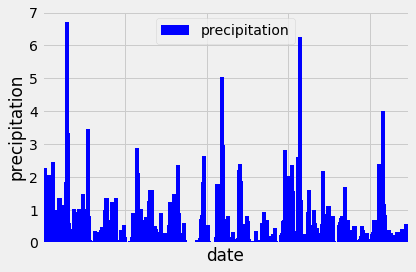

In [64]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(sort_prec_df))
precipitation = sort_prec_df['precipitation'].values.tolist()

plt.bar(x_axis,precipitation,color="b", align="center",label='precipitation', width=25)
plt.xlabel('date')
plt.ylabel('precipitation')
plt.legend(loc='upper center')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.xlim(-10,len(precipitation)+10)
plt.tight_layout()
plt.savefig("precipitation.png")
plt.show()

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sort_prec_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
